<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/NN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification


## Data Preprocessing

In [1]:
from sklearn.datasets import make_circles

### Create 1000 circle sample

In [2]:
n_samples=1000
X, y= make_circles(n_samples, 
                   noise=0.03,
                   random_state=42)
len(X), len(y)

(1000, 1000)

### Creating DataFrame

In [3]:
import pandas as pd
circles= pd.DataFrame({"X1":X[:,0], 
                       "X2":X[:,1],
                       "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### Visualizing Data

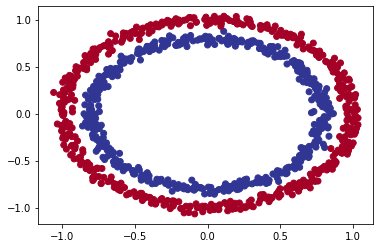

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

###Checking input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
import torch

### Turn Data into Tensors

In [7]:
X=torch.from_numpy(X).type(dtype=torch.float)
y=torch.from_numpy(y).type(dtype=torch.float)

###Split Data into training and test set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model


In [9]:
import torch 
from torch import nn

In [10]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create a model (Subclassing `nn.Module`)

In [11]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))
  
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### Setup loss function and optimizer


In [14]:
#Setup the loss function

# Without built-in sigmoid activation function
# loss_fn=nn.BCELoss()

# With built-in sigmoid activation function
loss_fn= nn.BCEWithLogitsLoss()
# Our model output are going to be raw LOGITs.

In [15]:
#Setup the Optimizer

optimizer= torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [16]:
#Calculate the accuracy
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))*100
  return acc

## Train Model

### Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [17]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1594],
        [ 0.3205],
        [-0.3004],
        [ 0.2898],
        [-0.3598]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5398],
        [0.5794],
        [0.4255],
        [0.5720],
        [0.4110]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [19]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 0., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Building Training and Test Loop

In [21]:
torch.manual_seed(42)

#Set the number of epoch
epochs=200

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Building training and evaluation loop:
for epoch in range(epochs):
  #Training
  model_0.train()

  ##Forward Pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) #turn logit -> pred probp -> pred label
  
  ##Claculate Loos/Accuracy
  loss = loss_fn(y_logits, y_train) ##nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  ##Optimizer zero grad
  optimizer.zero_grad()

  ##Loss backward - Backward Propagation
  loss.backward()

  ##Optimizer Step
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():

    ##Forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    ##Claculate Test Loos/ Accuracy
    test_loss = loss_fn(test_logits, y_test) ##nn.BCEWithLogitsLoss expects raw logits as input
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  #Print th result
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70148, Accuracy: 50.38% | Test loss: 0.71342, Test acc: 45.50%
Epoch: 10 | Loss: 0.69900, Accuracy: 50.75% | Test loss: 0.70998, Test acc: 45.00%
Epoch: 20 | Loss: 0.69742, Accuracy: 50.75% | Test loss: 0.70732, Test acc: 45.50%
Epoch: 30 | Loss: 0.69631, Accuracy: 51.00% | Test loss: 0.70519, Test acc: 46.00%
Epoch: 40 | Loss: 0.69550, Accuracy: 51.00% | Test loss: 0.70347, Test acc: 45.50%
Epoch: 50 | Loss: 0.69490, Accuracy: 51.00% | Test loss: 0.70207, Test acc: 45.50%
Epoch: 60 | Loss: 0.69444, Accuracy: 51.00% | Test loss: 0.70092, Test acc: 45.50%
Epoch: 70 | Loss: 0.69410, Accuracy: 51.00% | Test loss: 0.69997, Test acc: 45.50%
Epoch: 80 | Loss: 0.69384, Accuracy: 51.00% | Test loss: 0.69919, Test acc: 45.50%
Epoch: 90 | Loss: 0.69364, Accuracy: 51.00% | Test loss: 0.69854, Test acc: 46.00%
Epoch: 100 | Loss: 0.69349, Accuracy: 51.00% | Test loss: 0.69799, Test acc: 46.00%
Epoch: 110 | Loss: 0.69337, Accuracy: 51.00% | Test loss: 0.69752, Test acc: 46.00%
Epo

### Make predictions and evaluate the model

In [22]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File already existed")
else:
  print("Downloading")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb")as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Downloading


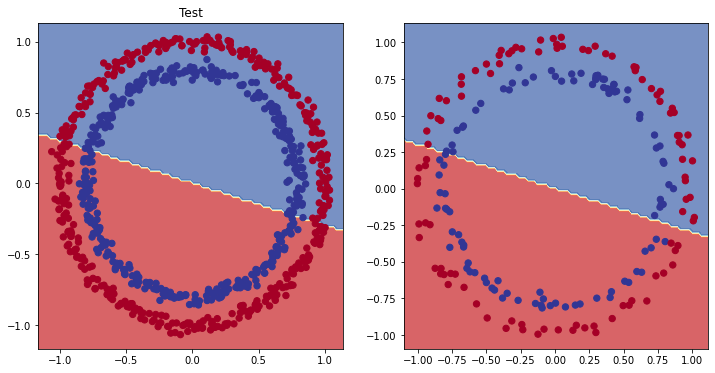

In [23]:
# Plot Decision boundry of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.title("Test")
plt.subplot(1,2,2)
plot_decision_boundary(model_0, X_test, y_test)

## Imporving model
* Add more layers - give the model more 
* chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Preparing data to see if our model can fit a straight line

In [25]:
# Create some data
weight=0.7
bias=0.3
start=0
end=1
step= 0.01

X_regression= torch.arange(start, end, step).unsqueeze(dim=1)
y_regression= weight * X_regression +bias 

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [26]:
train_split= int(0.8* len(X_regression))
X_train_regression , y_train_regression= X_regression[:train_split], y_regression[:train_split]

In [27]:
X_test_regression , y_test_regression= X_regression[train_split:], y_regression[train_split:]

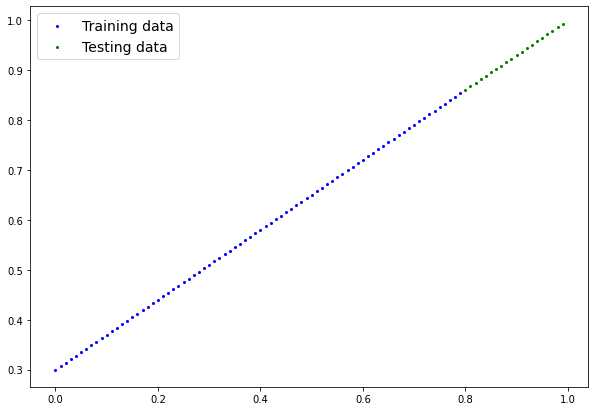

In [28]:
plot_predictions(train_data= X_train_regression, 
                 train_labels= y_train_regression,
                 test_data= X_test_regression, 
                 test_labels= y_test_regression)

In [29]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
model_2= nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.L1Loss()
optimizer= torch.optim.SGD(params= model_2.parameters(),
                            lr=1e-1)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train_regression, y_train_regression= X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression= X_test_regression.to(device), y_test_regression.to(device)

epochs=1000

for epoch in range(epochs):
  #Training the model
  model_2.train()
  #Forward Propagation
  y_pred=model_2(X_train_regression)
  #Loss Function
  loss= loss_fn(y_pred, y_train_regression)
  #Optimizer. zero_grad
  optimizer.zero_grad()
  #Loss Backward Propagation
  loss.backward()
  #optimzer step
  optimizer.step()

  #Testing The model
  model_2.eval()
  with torch.inference_mode():
    #Forward propagation
    y_pred_test= model_2(X_test_regression)
    #Loss Function
    loss_test= loss_fn(y_pred_test, y_test_regression)
  if epoch % 100==0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {loss_test}")




Epoch: 0 | Train Loss: 0.5789582133293152 | Test Loss: 0.47265034914016724
Epoch: 100 | Train Loss: 0.056523896753787994 | Test Loss: 0.17491017282009125
Epoch: 200 | Train Loss: 0.052717920392751694 | Test Loss: 0.15037743747234344
Epoch: 300 | Train Loss: 0.05732901766896248 | Test Loss: 0.147325798869133
Epoch: 400 | Train Loss: 0.05779900774359703 | Test Loss: 0.14757660031318665
Epoch: 500 | Train Loss: 0.049426037818193436 | Test Loss: 0.12419328838586807
Epoch: 600 | Train Loss: 0.052835654467344284 | Test Loss: 0.14349626004695892
Epoch: 700 | Train Loss: 0.07243765890598297 | Test Loss: 0.12573714554309845
Epoch: 800 | Train Loss: 0.04493461921811104 | Test Loss: 0.11134850233793259
Epoch: 900 | Train Loss: 0.053771138191223145 | Test Loss: 0.13251811265945435


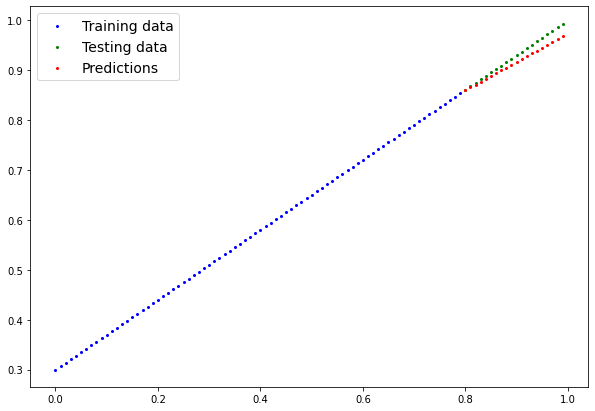

In [33]:
model_2.eval()

with torch.inference_mode():
  y_preds=model_2(X_test_regression)

plot_predictions(train_data= X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(), 
                 test_labels= y_test_regression.cpu(),
                 predictions= y_preds.cpu())

Recreating non_linear dataset

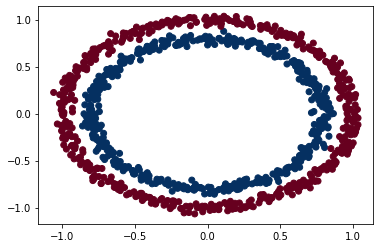

In [68]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y= make_circles(1000, 
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [69]:
import torch
from sklearn. model_selection import train_test_split

X = torch.from_numpy(X).type(dtype= torch.float)
y = torch.from_numpy(y). type(dtype= torch.float)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

X=X.to(device)
y=y.to(device)



In [70]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
  def forward(self, x):
    x= self.layers(x)
    return x
model_3= CircleModelV2().to(device)
model_3

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [71]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD(model_3.parameters(),
                           lr=1e-1)

In [72]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

epochs=1000

for epoch in range(epochs):
  #Taining model
  model_3.train()

  #Forward propagaation
  y_logit=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logit))

  # Loss Function
  loss= loss_fn(y_logit, y_train)
  acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
  #Optimizer zero grad
  optimizer.zero_grad()

  #loss Backward propagation
  loss.backward()
  #optimizer step
  optimizer.step()

  #Testing model
  model_3.eval()
  with torch.inference_mode():
    #Forward propagation
    test_logit=model_3(X_test).squeeze()
    test_pred= torch.round(torch.sigmoid(test_logit))
    #Loss 
    test_loss= loss_fn(test_logit, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

  if epoch %100==0:
    print(f"epoch: {epoch} | Loss: {loss} | Acc: {acc} | Test Loss: {test_loss} | Acc test: {test_acc} ")

epoch: 0 | Loss: 0.6929463148117065 | Acc: 50.0 | Test Loss: 0.6931881308555603 | Acc test: 50.0 
epoch: 100 | Loss: 0.691152811050415 | Acc: 52.87500000000001 | Test Loss: 0.6910240054130554 | Acc test: 52.5 
epoch: 200 | Loss: 0.6897743940353394 | Acc: 53.37499999999999 | Test Loss: 0.6893960237503052 | Acc test: 55.00000000000001 
epoch: 300 | Loss: 0.6879494190216064 | Acc: 53.0 | Test Loss: 0.6872316002845764 | Acc test: 56.00000000000001 
epoch: 400 | Loss: 0.6851678490638733 | Acc: 52.75 | Test Loss: 0.6841148138046265 | Acc test: 56.49999999999999 
epoch: 500 | Loss: 0.6810224652290344 | Acc: 52.75 | Test Loss: 0.6794120073318481 | Acc test: 56.49999999999999 
epoch: 600 | Loss: 0.675148606300354 | Acc: 54.50000000000001 | Test Loss: 0.6728507876396179 | Acc test: 56.00000000000001 
epoch: 700 | Loss: 0.6665886044502258 | Acc: 58.375 | Test Loss: 0.6632164716720581 | Acc test: 59.0 
epoch: 800 | Loss: 0.6515954732894897 | Acc: 64.0 | Test Loss: 0.647568941116333 | Acc test: 67.

In [78]:
# Make predictions
model_3.to("cuda")
model_3.eval()
with torch.inference_mode():
    y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y_test[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

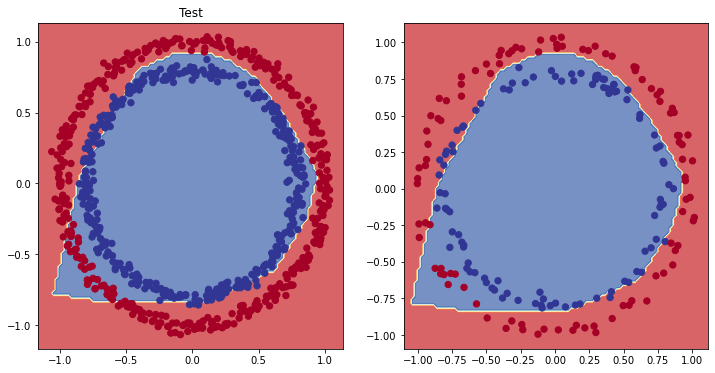

In [73]:
# Plot Decision boundry of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.title("Test")
plt.subplot(1,2,2)
plot_decision_boundary(model_3, X_test, y_test)

In [79]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

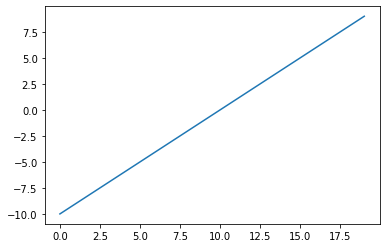

In [80]:
# Visualize the toy tensor
plt.plot(A);

In [81]:
# Create ReLU function by hand 
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

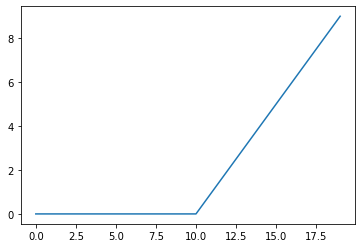

In [82]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [83]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

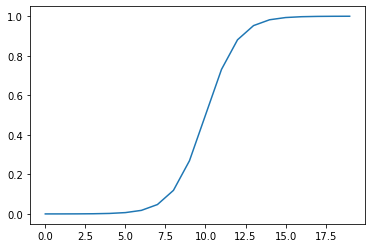

In [84]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));